In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.optimize import fsolve, root
import copy
pi = math.pi

In [154]:
### data init for measurement simulation
f = spio.loadmat('sphere_render/dm_and_N.mat', squeeze_me=True) 
dm = f['dm'] 

ymax, xmax = dm.shape

N = f['N']
phis = np.arctan2(N[:,:,1], N[:,:,0])
thetas = np.arccos(N[:,:,2])

env1 = np.load("sphere_render/ball_glacier.npy")
env2 = np.load("sphere_render/ball_grace_new.npy")

# setting incident light properties
Iups = env2
Ips = env1

Iups[Iups>4] = 4
Iups = np.sqrt(np.sqrt(Iups))
Iups[np.isnan(dm)] = 0

Ips = np.sqrt(Ips)
Ips[np.isnan(dm)] = 0

psis = np.zeros((ymax, xmax))
psis = (Ips + np.sqrt(thetas))**2
psis = psis * pi / psis.max()

# setting ball properties n2 = n^2
n2 = 2.56

# simulating polarizer measurements
angles = [0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6]
I = np.zeros((ymax, xmax, len(angles)))

xmap = np.zeros((200,200))
ymap = np.zeros((200,200))

In [155]:
for x in range(0, xmax):
    for y in range (0, ymax):
        Iup = Iups[y,x]
        Ip = Ips[y,x]
        ps = psis[y,x]
        sps2 = (math.sin(ps))**2
        cps2 = (math.cos(ps))**2
        tps = math.tan(ps)
        th = thetas[y,x]
        ph = phis[y,x]
        if (~np.isnan(dm[y,x])):
            thmap = int(math.floor(th*200/(pi/2+0.1)))
            phmap = int(math.floor((ph+pi)*200/(2*pi+0.1)))
            xmap[thmap,phmap] = x
            ymap[thmap,phmap] = y
        else:
            for i, angle in enumerate(angles):
                I[y,x,i] = 0
            continue
        cth = math.cos(th)
        sth = math.sin(th)
        Rs = ((cth - math.sqrt(n2 - sth**2))/(cth + math.sqrt(n2 - sth**2)))**2
        Rp = ((-n2*cth + math.sqrt(n2 - sth**2))/(n2*cth + math.sqrt(n2 - sth**2)))**2

        for i, angle in enumerate(angles):
            I[y,x,i] = (Iup/2) * (Rs*(math.sin(ph - angle))**2 + Rp*(1 - (math.sin(ph - angle))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angle))**2


In [41]:
x0=220
y0=320
ph0 = phis[y0,x0]
th0 = thetas[y0,x0]
print(ph0,th0)

-1.9660699254406884 0.7722915435536322


In [143]:
def system_test (p, *args):
    angles = [0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6]
    ph, th, n = p
#     I = args
    thmap = int(math.floor(th*xmap.shape[0]/(pi/2+0.1)))
    phmap = int(math.floor((ph+pi)*xmap.shape[1]/(2*pi+0.1)))
    if (0<thmap<200) and (0<phmap<200):
        x = int(xmap[thmap,phmap])
        y = int(ymap[thmap,phmap])
    else:
        x = y = 0


    Iup = Iups[y,x]
    Ip = Ips[y,x]
    ps = psis[y,x]
#     Ii = I[y,x,:].flatten()
#     print (y,x,Iup, Ip, ps, Ii)
#     print (Ii[0])
    if (np.isnan(dm[y,x])) or ((max(Ii)-min(Ii))<0.001):
        return (100, 100, 100, 100, 100, 100)
    return (
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[0]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[0]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[0]))**2 - Ii[0],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[1]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[1]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[1]))**2 - Ii[1],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[2]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[2]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[2]))**2 - Ii[2],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[3]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[3]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[3]))**2 - Ii[3],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[4]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[4]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[4]))**2 - Ii[4],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[5]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[5]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[5]))**2 - Ii[5]
    )

In [157]:
# going through all angles with fixed n

n = 1.6
Ii = I[y0,x0,:].flatten()
sz = 1000

res = np.zeros((sz, sz))

psj = -pi
for ii in range(0,sz):
    psj += 2*pi/sz
    thj = 0
    for jj in range(0,sz):
        thj += (pi/2)/sz
        res1 = system_test((psj, thj, n), (Ii))
        res1 = [abs(xx) for xx in res1]
        res[ii, jj] = sum(res1)
        

In [142]:
pss = -pi + 364*2*pi/sz
ths = 525*(pi/2)/sz
res1 = system_test((pss, ths, n), (Ii))
print(res1)
res1 = [abs(xx) for xx in res1]
res = sum(res1)
print (res)

311 303 1.0 0.0 0.0 [0.04902604 0.02529965 0.00804397 0.01451468 0.03824107 0.05549675]
0.0490260404826867
(-0.01129606741690519, 0.03511733110311392, 0.04841031625254462, 0.015289902881956214, -0.031123495638062864, -0.0444164807874936)
0.18565359408007642


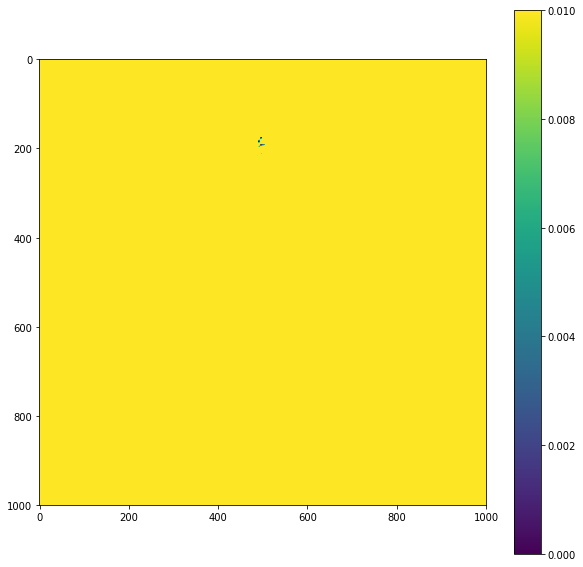

In [158]:
plt.figure(figsize=(10,10))
plt.imshow(res)
plt.colorbar()
plt.clim(0,0.01)
plt.show()

In [162]:
ind = np.unravel_index(np.argmin(res, axis=None), res.shape)
print(ind, res[ind])
print (indtoangle(ind[0], ind[1]))
print (ph0,th0)
ff = angletoind(ph0,th0)
print (ff, res[ff[0], ff[1]])

(186, 491) 0.0003095406244539335
(-1.9352210746113125, 0.7712609964562943)
-1.9660699254406884 0.7722915435536322
(180, 460) 0.08921606728361504


In [ ]:
def pied (x):
    while x>pi:
        x -= pi
    return (x)

def pi2ed (x):
    while x>pi/2:
        x -= pi/2
    return (x)

data = np.load("sphere_render/meas_simulation.npz")
Is = data['I']
Iups = data['Iups']
Ips = data['Ips']
psis = data['psis']
xmap = data['xmap']
ymap = data['ymap']
phis0 = data['phis']
thetas0 = data['thetas']
dm = data['dm']

ymax, xmax, imax = Is.shape

phis = np.zeros((ymax,xmax))
thetas = np.zeros((ymax,xmax))
ns = np.zeros((ymax,xmax))

ph = 1
th = 1
n = 1.6
kol = 0
fal = 0

In [17]:
def nearest_nonzero_idx(a,x,y):
    idx = np.argwhere(a)
    return idx[((idx - [x,y])**2).sum(1).argmin()]

def fill_with_neasest(ymap):
    a = copy.deepcopy(ymap)
    for y in range (0, ymap.shape[0]):
        for x in range(0,ymap.shape[0]):
            if a[y,x] == 0:
                y1, x1 = nearest_nonzero_idx(a, y, x)
                a[y,x] = a[y1,x1]
    return a

In [36]:
def indtoangle (psj, thj):
    return (psj*2*pi/1000 - pi, thj*(pi/2)/1000)

def angletoind (ph, th):
    thmap = int(math.floor(th*xmap.shape[0]/(pi/2+0.1)))
    phmap = int(math.floor((ph+pi)*xmap.shape[1]/(2*pi+0.1)))
    return (phmap*5, thmap*5)

In [38]:
def system (p, *args):
    angles = [0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6]
    ph, th, n = p
    I = args
    thmap = int(math.floor(th*xmap.shape[0]/(pi/2+0.1)))
    phmap = int(math.floor((ph+pi)*xmap.shape[1]/(2*pi+0.1)))
    if (0<thmap<200) and (0<phmap<200):
        x = int(xmap[thmap,phmap])
        y = int(ymap[thmap,phmap])
    else:
        x = y = 0
#     plt.imshow(psis)
#     plt.colorbar()
#     plt.show()
#     print (y, x)
#     y = 310
#     x = 310
    Iup = Iups[y,x]
    Ip = Ips[y,x]
    ps = psis[y,x]
    I = Is[y,x,:].flatten()
#     print (Iup, Ip, ps, I)
#     if (Iup==0) or (Ip == 0):
#         return (100, 100, 100, 100, 100, 100)
    return (
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[0]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[0]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[0]))**2 - I[0],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[1]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[1]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[1]))**2 - I[1],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[2]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[2]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[2]))**2 - I[2],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[3]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[3]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[3]))**2 - I[3],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[4]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[4]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[4]))**2 - I[4],
        (Iup/2) * (((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(math.sin(ph - angles[5]))**2 + (((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*(1 - (math.sin(ph - angles[5]))**2)) + Ip*((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.cos(ps))**2) + ((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)*((math.sin(ps))**2))*(math.cos(math.atan((math.tan(ps))*math.sqrt((((-n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2))/(n**2*(math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2)/((((math.cos(th)) - math.sqrt(n**2 - (math.sin(th))**2))/((math.cos(th)) + math.sqrt(n**2 - (math.sin(th))**2)))**2))) + ph - angles[5]))**2 - I[5]
    )

def system1 (p, *args):
    angles = [0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6]
    ph, th, n = p
    I = args[0]
#     print (I)
    thmap = int(math.floor(th*xmap.shape[0]/(pi/2+0.1)))
    phmap = int(math.floor((ph+pi)*xmap.shape[1]/(2*pi+0.1)))
    if (0<thmap<200) and (0<phmap<200):
        x = int(xmap[thmap,phmap])
        y = int(ymap[thmap,phmap])
    else:
        x = y = 0
    Iup = Iups[y,x]
    Ip = Ips[y,x]
    ps = psis[y,x]
#     if 1.5<n<1.7:
#         return(100,100,100,100,100,100)
    n2 = n**2
    if n2 < 1:
        n2 = n2 + 1
    Ip = 0
    ps = 0
    sps2 = (math.sin(ps))**2
    cps2 = (math.cos(ps))**2
    tps = math.tan(ps)
    cth = math.cos(th)
    sth = math.sin(th)
#     print (n2, sth)
    Rs = ((cth - math.sqrt(n2 - sth**2))/(cth + math.sqrt(n2 - sth**2)))**2
    Rp = ((-n2*cth + math.sqrt(n2 - sth**2))/(n2*cth + math.sqrt(n2 - sth**2)))**2
#     print (I)
    return (
        (Iup/2) * (Rs*(math.sin(ph - angles[0]))**2 + Rp*(1 - (math.sin(ph - angles[0]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[0]))**2 - I[0],
        (Iup/2) * (Rs*(math.sin(ph - angles[1]))**2 + Rp*(1 - (math.sin(ph - angles[1]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[1]))**2 - I[1],
        (Iup/2) * (Rs*(math.sin(ph - angles[2]))**2 + Rp*(1 - (math.sin(ph - angles[2]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[2]))**2 - I[2],
        (Iup/2) * (Rs*(math.sin(ph - angles[3]))**2 + Rp*(1 - (math.sin(ph - angles[3]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[3]))**2 - I[3],
        (Iup/2) * (Rs*(math.sin(ph - angles[4]))**2 + Rp*(1 - (math.sin(ph - angles[4]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[4]))**2 - I[4],
        (Iup/2) * (Rs*(math.sin(ph - angles[5]))**2 + Rp*(1 - (math.sin(ph - angles[5]))**2)) + Ip*(Rp*cps2 + Rs*sps2)*(math.cos(math.atan(tps*math.sqrt(Rp/Rs)) + ph - angles[5]))**2 - I[5],
        n2 - 2.56
    )

In [44]:
xmap = fill_with_neasest(xmap)
ymap = fill_with_neasest(ymap)

In [9]:
# going through all angles and ns
y = 210
x = 310
ph = phis0[y,x]
th = thetas0[y,x]
n = 1.6
I = Is[y,x,:].flatten()

res = np.zeros((400, 400, 10))

nl = 1
for ll in range (0, 10):
    nl += 0.1
    psj = -pi
    for ii in range(0,400):
        psj += 2*pi/400
        thj = 0
        for jj in range(0,400):
            thj += (pi/2)/400
            res1 = system((psj, thj, nl), (I))
            res1 = [abs(xx) for xx in res1]
            res[ii, jj, ll] = sum(res1)
        

In [39]:
# going through all angles with fixed n
y = 210
x = 310
ph = phis0[y,x]
th = thetas0[y,x]
n = 1.6
I = Is[y,x,:].flatten()
sz = 1000

res = np.zeros((sz, sz))

psj = -pi
for ii in range(0,sz):
    psj += 2*pi/sz
    thj = 0
    for jj in range(0,sz):
        thj += (pi/2)/sz
        res1 = system((psj, thj, n), (I))
        res1 = [abs(xx) for xx in res1]
        res[ii, jj] = sum(res1)
        

In [55]:
ind = np.unravel_index(np.argmin(res, axis=None), res.shape)
print(ind, res[ind])
print (indtoangle(ind[0], ind[1]))
print (ph,th)
ff = angletoind(ph,th)
print (ff, res[ff[0], ff[1]])

(961, 116) 0.004989580243199069
(2.8965484266097894, 0.18221237390820802)
0.5793647149459809 0.7289382015272396
(580, 435) 0.12001362055477466


In [48]:
xmap.shape

(200, 200)

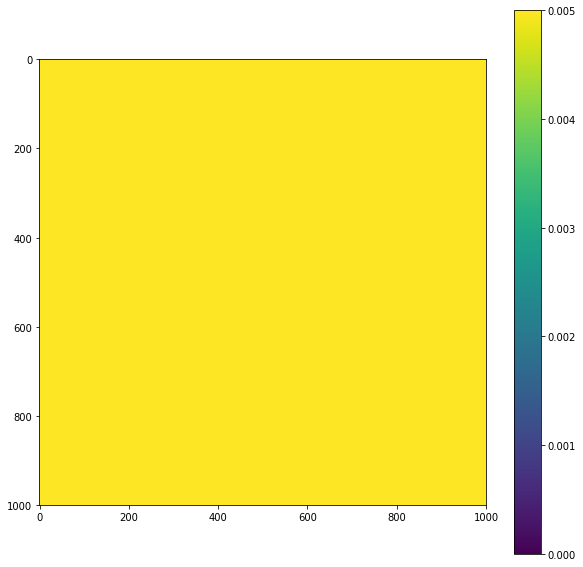

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(res)
plt.colorbar()
plt.clim(0,0.005)
plt.show()

In [ ]:
y = 300
x = 250
ph = phis0[y,x]
th = thetas0[y,x]
th0 = 0.9
ph0 = 1.1
n = 1.6
I = Is[y,x,:].flatten()

sol = root(system1, (ph0, th0, 1.6), args=(I), method='lm', tol=0.000001)
print (sol.x[0], th, sol.x[2], system1((sol.x[0], sol.x[1], sol.x[2]),(I)))
print (ph, th, n, system1((ph, th, n),(I)))

In [ ]:
ph = 1.1
th = 0.9
phis = np.zeros((ymax,xmax))
thetas = np.zeros((ymax,xmax))
ns = np.zeros((ymax,xmax))
for y in range(0, 500):
    if y%100 == 0:
        print ("y =", y)
    for x in range (0, 500):
        if np.isnan(dm[y,x]):
            continue

        I = Is[y,x,:].flatten()
        sol = root(system1, (1.1, 0.9, 1.6), args=(I), method='lm', tol=0.00001)
            
        ph = pied(sol.x[0])
        th = pi2ed(sol.x[1])
        phis[y,x] = sol.x[0]
        thetas[y,x] = sol.x[1]
        ns[y,x] = sol.x[2]
        ress = system1((sol.x[0], sol.x[1], sol.x[2]), (I))
        ress1 = [abs(xx) for xx in ress]
#         print (sum(ress1), sol.x[2])

In [ ]:
res1 = system1((1.5796033696071434, 0.9459872649068347, 1.997700058230306), (I))
# print (ph, th)
print (res1)
res1 = [abs(xx) for xx in res1]
res0 = sum(res1)
print ("real =", res0)

In [ ]:
phsh = -pi + 375*2*pi/1000
thsh = 823*pi/(2*1000)
print (phsh, thsh)
res1 = system((phsh, thsh, 1.6))
print (res1)

In [ ]:
phsh = -pi + 592*2*pi/1000
thsh = 464*pi/(2*1000)
print (phsh, thsh)
res1 = system((phsh, thsh, 1.6))
print (res1)

In [ ]:
# res[ind] = 1
thetas[250,249]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(phis)
plt.colorbar()
plt.clim(-pi,pi)
plt.show()


# 75*(pi/2+0.1)/100

In [ ]:
pi

### I get wrong minimum with 0 value. find the reason. 

Unfortunately, the method generates faulty mins. On the example above (50, 70) is the minimum, although not the correct one. And correct one won't appear, because 1 pixel error in remapping make it bigger than phantom min. This can be fixed in the simulation but won't work stable in the actual system.

In [ ]:
Run tests with:
    ps = 0
    Ip = 0
    
and see if I get classic results

In [ ]:
Is = data['I']
Iups = data['Iups']
Ips = data['Ips']
psis = data['psis']
xmap = data['xmap']
ymap = data['ymap']
phis0 = data['phis']
thetas0 = data['thetas']
dm = data['dm']

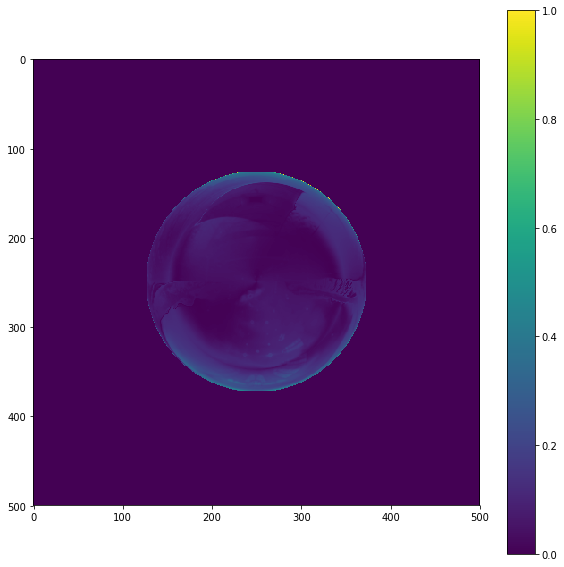

In [156]:
plt.figure(figsize=(10,10))
plt.imshow(I[:,:,1])
plt.colorbar()
plt.clim(0,1)
plt.show()

In [139]:
I[311,303,1] = 10